In [718]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [719]:
def show_image(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()
    # print("Done")

def dist(p1, p2):
    return ((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

def show_points(img, p1, p2):
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    img = cv2.circle(img, p1, 3, (0, 0, 255), -1)
    img = cv2.circle(img, p2, 3, (255, 0, 0), -1)
    show_image(img)

def flipped(image):
    # Detect horizontal lines
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13,1))
    detect_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
    cnts = cv2.findContours(detect_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    miny = image.shape[0]
    for c in cnts:
        miny = min(miny, c[0][0][1])
    # show_points(gray, (0, miny), (image.shape[1]//2, miny))
    above = (np.sum(thresh[:miny, :]))/255
    # print(above)
    if above > 450:
        return True

    return False

def find_slope_math(image):
    xmax = 0
    ymax = 0
    xmin = image.shape[1]
    ymin = image.shape[0]

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i][j] == 255:
                if i > ymax:
                    bottom_y = j,i
                    ymax = i
                if i < ymin:
                    top_y = j,i
                    ymin = i
                if j > xmax:
                    right_x = j,i
                    xmax = j
                if j < xmin:
                    left_x = j, i
                    xmin = j

    # print(top_y, bottom_y, left_x, right_x)
    # show_points(image, top_y, bottom_y)
    # show_points(image, left_x, right_x)
    # print(dist(left_x, right_x))

    left, right = ((left_x, right_x) if dist(left_x, right_x) > dist(top_y, bottom_y) else (top_y, bottom_y))

    if(left[0] > right[0]):
        left, right = right, left

    # show_points(image, left, right)
    # print(left, right)
    
    slope = np.arctan((right[1] - left[1])/(right[0] - left[0])) if right[0] != left[0] else np.pi/2
    
    return slope

def find_slope_fun(image):
    X, Y = np.where(image == 255)
    a, b = np.polyfit(X, Y, 1)
    # plt.scatter(X, Y)
    # plt.plot(X, a*X+b)  
    # plt.show()

    return a 

def make_image_square(image):
    target_size = int((image.shape[0]**2 + image.shape[1]**2) ** 0.5)
    square_image = np.ones((target_size, target_size, 3), dtype=np.uint8) * 255
    x_offset = (target_size - image.shape[1]) // 2
    y_offset = (target_size - image.shape[0]) // 2
    square_image[y_offset:(y_offset + image.shape[0]), x_offset:(x_offset + image.shape[1])] = image
    # print(square_image.shape)
    return square_image


In [720]:
def solution(image_path):
    ############################
    ############################
    
    original_image = cv2.imread(image_path)
    original_image = make_image_square(original_image)
    # show_image(original_image)
    
    # original_image = cv2.copyMakeBorder(original_image, 0, 0, original_image.shape[0]//2, original_image.shape[0]//2, cv2.BORDER_CONSTANT, value=[255,255,255]) # add padding to the image to avoid cropping after rotation
    gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    thresh_val, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) # perform OTSU thresholding
    # show_image(thresh)
    ## Testing code to display the image (Remove indent to run this code)
        # print("Threshold value: ", thresh_val)
        # show_image(thresh)

    fourier = cv2.dft(np.float32(thresh), flags=cv2.DFT_COMPLEX_OUTPUT)
    # Shift the zero-frequency component to the center of the spectrum
    fourier_shift = np.fft.fftshift(fourier)
    
    # calculate the magnitude of the Fourier Transform
    magnitude = 20*np.log(cv2.magnitude(fourier_shift[:,:,0],fourier_shift[:,:,1]))
    
    # Scale the magnitude for display
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)

    image = cv2.threshold(magnitude, 210, 255, cv2.THRESH_BINARY)[1] # threshold the magnitude image to get frquenncies corresponding to shiro rekhas
    # show_image(image)

    
    slope = find_slope_fun(image)
    # print(slope)

    angle = np.arctan(slope) * (180 / np.pi)
    # print(angle)

    angle = -angle

    # if angle < 0:
    #     angle = 90 + angle - (20 if (-70<angle<-20) else 0) #adding 5 for correction by observation
    # else:
    #     angle = -(90-angle) + (20 if (20<angle<70) else 0)

    image = original_image
    h,w = image.shape[:2]
    cX, cY = (w//2, h//2)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    image = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REPLICATE)
    if flipped(image): #if image is flipped, rotate by 180
        image = cv2.rotate(image, cv2.ROTATE_180)

    # show_image(image)
    # print(angle)
    
    ############################
    return image
    


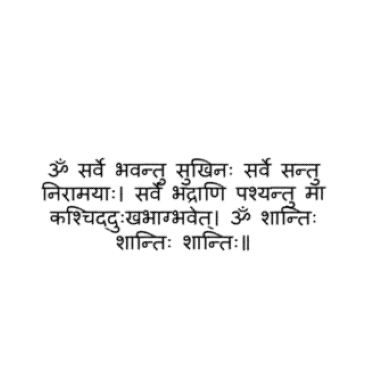

In [721]:
show_image(solution("test/3_a.png"))  

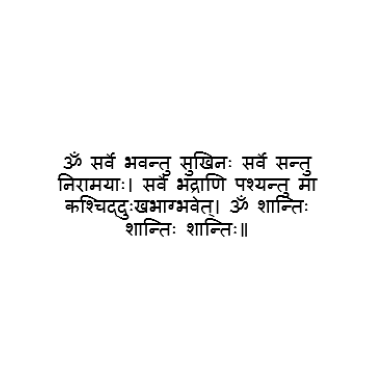

In [722]:
show_image(solution("test/3_b.png"))  

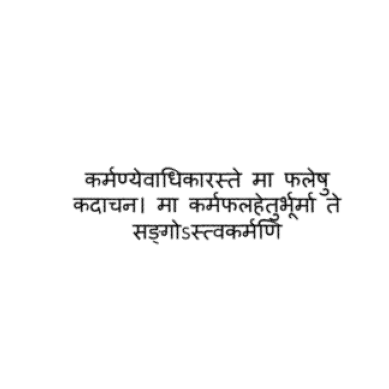

In [723]:
show_image(solution("test/3_c.png"))  

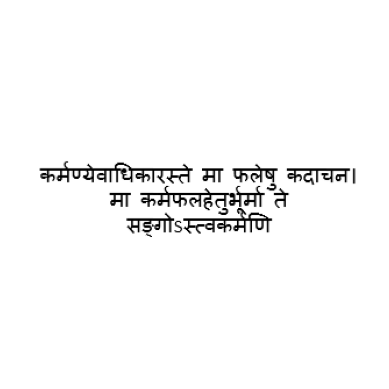

In [724]:
show_image(solution("test/3_d.png"))    